# **Designing proteins using ProteinMPNN**

---

**Robust deep learning–based protein sequence design using ProteinMPNN**

*J. Dauparas, I. Anishchenko, N. Bennett, H. Bai, R. J. Ragotte, L. F. Milles, B. I. M. Wicky, A. Courbet, R. J. de Haas, N. Bethel, P. J. Y. Leung, T. F. Huddy, S. Pellock, D. Tischer, F. Chan, B. Koepnick, H. Nguyen, A. Kang, B. Sankaran, A. K. Bera, N. P. King and D. Baker* [(link to paper)](https://doi.org/10.1126/science.add2187)

---


ProteinMPNN is a efficient and fast method to sample sequences for a given protein backbone. ProteinMPNN therefore attempts to solve the so-called inverse folding problem, i.e. to find a sequence that matches a protein backbone. For every position the network predicts the log-likelyhood of the 20 possible canonical amino acids and generate sequences based on the probabilitys and a random decoding order.

It can be used for different kinds of protein design challenges in which the backbone structure of the protein should stay fixed. Successful improvement in solubility and subsequently soluble protein yields have been already shown for monomers and homo-oligomers as well as improvement in yield and binding for de novo designed miniportein binder.

In this tutorial we will use the implementation of ProteinMPNN in [Colabdesign](https://github.com/sokrypton/ColabDesign), because we also wanna use ColabFold to predict our designed sequences as an validation step. This notebook is based on an MPNN notebook by Sergey Ovchinnikov (so3@mit.edu).  
https://colab.research.google.com/github/sokrypton/ColabDesign/blob/main/mpnn/examples/proteinmpnn_in_jax.ipynb

---

Before we can start we need to install all things we will use throughout the notebook and setup the environment. Run the **Setup** cells to do that. It will install ProteinMPNN, ColabDesign, pyrosetta and setup a couple different helper functions to use.

## What you can do with this notebook

- Running ProteinMPNN for a struture from the PDB, a Alphafold structure based on the UniProt ID or any structure you can upload
   - using different types (weights) of ProteinMPNN for design
   - fixing chains, positions or specify things you want to design
- predict structures for generated sequences using Alphafold

and some additonal helper functions to
- look into ProteinMPNN results
   - Plotting the resulting sequence logo for design
   - Visualizing probability heatmaps
   - Filtering generated sequences based on MPNN scores
- Display PDB structures
- Identify protein interfaces / layers (core, boundary, surface)
- Identify neighbours of selected residues
- Calculate interface metrics for binders
- Thread generated sequences on structures

## **Setup**

In [ ]:
%%time
#@title Install **pyrosetta** and **colabdesign** (run this cell only once)

#@markdown The notebook must be connected to Google Drive. Installation should take ~3-5 minutes.

#@markdown We also download the alphafold params.

# Install pyrosetta
!pip install pyrosettacolabsetup
import pyrosettacolabsetup;
pyrosettacolabsetup.install_pyrosetta(serialization=True, cache_wheel_on_google_drive=True)

!pip install gdown py3dmol git+https://github.com/RosettaCommons/pyrosetta_viewer3d --quiet
!pip install logomaker

# Install colabdesign
import os
try:
  import colabdesign
except:
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git")
  os.system("ln  /usr/local/lib/python3.7/dist-packages/colabdesign colabdesign")

from colabdesign.mpnn import mk_mpnn_model, clear_mem
from colabdesign.shared.protein import pdb_to_string

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import tqdm.notebook
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

from google.colab import files
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Download af model
print('==============================\n\nDownload AF models')
if not os.path.isdir("params"):
  os.system("mkdir params")
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
  os.system("tar -xf alphafold_params_2022-12-06.tar -C params")


Mounted at /content/google_drive

Note that USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE.
See https://github.com/RosettaCommons/rosetta/blob/main/LICENSE.md or email license@uw.edu for details.

Looking for compatible PyRosetta wheel file at google-drive/PyRosetta/colab.bin//wheels.serialization...
Found compatible wheel: /content/google_drive/MyDrive/PyRosetta/colab.bin/wheels.serialization//content/google_drive/MyDrive/PyRosetta/colab.bin/wheels.serialization/pyrosetta-2024.42+release.3366cf78a3-cp310-cp310-linux_x86_64.whl


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 21.9 MB/s eta 0:00:00
   ━

In [ ]:
%%time
#@title Initialize **pyrosetta**

import pyrosetta; # import the pyrosetta package to access functionality
import pyrosetta.distributed.io as io
pyrosetta.init("-corrections::beta_nov16 -ignore_unrecognized_res true -mute all") # must be called before any other pyrosetta functions. Can accept command line flags
import viewer3d
from google.colab import files

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.ubuntu.cxx11thread.serialization 2024.42+release.3366cf78a3df04339d1982e94531b77b098ddb99 2024-10-11T08:24:04] retrieved from: http://www.pyrosetta.org


CPU times: user 149 ms, sys: 17.6 ms, total: 167 ms
Wall time: 331 ms


In [ ]:
#@title **Helper functions** for selection, downloading and visualisation
import os

def compare_poses(original_pdb, pdb_string, color, show_sidechains, show_mainchains, animate, color_HP):
  import py3Dmol
  from colabdesign.shared.protein import alphabet_list
  view = py3Dmol.view(width=800, height=500)
  view.addModel(original_pdb,'pdb')
  hbondCutoff=4
  vmin=50
  vmax=90
  pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]
  if animate:
    view.addModelsAsFrames(pdb_string,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_string,'pdb')

  if color == "pLDDT":
    view.setStyle({'model': 1},{'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'model': 1},{'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'model': 1},{'chain':chain},{'cartoon': {'color':color}})
  else:
    view.setStyle({'model': 1}, {"cartoon": {'color': 'orange'}})

  view.setStyle({'model': 0}, {"cartoon": {'color': 'grey'}})

  if show_sidechains:
    BB = ['C','O','N']
    HP = ["ALA","GLY","VAL","ILE","LEU","PHE","MET","PRO","TRP","CYS","TYR"]
    if color_HP:
      view.addStyle({'model': 1,'and':[{'resn':HP},{'atom':BB,'invert':True}]},
                    {'stick':{'colorscheme':"yellowCarbon",'radius':0.3}})
      view.addStyle({'model': 1,'and':[{'resn':HP,'invert':True},{'atom':BB,'invert':True}]},
                    {'stick':{'colorscheme':"whiteCarbon",'radius':0.3}})
      view.addStyle({'model': 1,'and':[{'resn':"GLY"},{'atom':'CA'}]},
                    {'sphere':{'colorscheme':"yellowCarbon",'radius':0.3}})
      view.addStyle({'model': 1,'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                    {'stick':{'colorscheme':"yellowCarbon",'radius':0.3}})
    else:
      view.addStyle({'model': 1, 'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                    {'stick':{'colorscheme':f"OrangeCarbon",'radius':0.3}})
      view.addStyle({'model': 1,'and':[{'resn':"GLY"},{'atom':'CA'}]},
                    {'sphere':{'colorscheme':f"OrangeCarbon",'radius':0.3}})
      view.addStyle({'model': 1,'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                    {'stick':{'colorscheme':f"OrangeCarbon",'radius':0.3}})

    view.addStyle({'model': 0,'and':[{'resn':HP},{'atom':BB,'invert':True}]},
                    {'stick':{'colorscheme':f"BlueCarbon",'radius':0.3}})
    view.addStyle({'model': 0,'and':[{'resn':"GLY"},{'atom':'CA'}]},
                    {'sphere':{'colorscheme':f"BlueCarbon",'radius':0.3}})
    view.addStyle({'model': 0,'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                    {'stick':{'colorscheme':f"BlueCarbon",'radius':0.3}})

  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})


  view.zoomTo()
  if animate: view.animate()
  view.show()
  return None


def align_pdbs(ref_pdb_path, pdb_to_align_path):
  #from pyrosetta import scoring
  from pyrosetta import Pose,pose_from_pdb
  from pyrosetta.rosetta.core.scoring import calpha_superimpose_pose, CA_rmsd
  ref_pose = pose_from_pdb(ref_pdb_path)
  to_align_pose = pose_from_pdb(pdb_to_align_path)
  assert len(ref_pose.sequence()) == len(to_align_pose.sequence()), f"Unequal sequence lengths: ref {len(ref_pose.sequence())} vs align {len(to_align_pose.sequence())}"
  rmsd_start = CA_rmsd(to_align_pose, ref_pose)
  rmsd_end = calpha_superimpose_pose(to_align_pose, ref_pose)
  print("RMSD before alignment:"+str(rmsd_start))
  print("RMSD after alignment:"+str(rmsd_end))


# Helper to get PDB
def get_pdb(pdb_code="", outfolder=""):
  if outfolder != "":
    os.system(f"mkdir -p {outfolder}")
    wget_suff = f'-P {outfolder}'
  else:
    wget_suff = ""
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    p = os.path.join(outfolder, "tmp.pdb")
    with open(p, "wb") as out:
      out.write(pdb_string)
    return p
  elif os.path.isfile(os.path.join(outfolder, pdb_code)):
    return os.path.join(outfolder, pdb_code)
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb {wget_suff}")
    p = os.path.join(outfolder, f"{pdb_code}.pdb")
    assert os.path.isfile(p), "Specified PDB id with length 4: Could not be downloaded from PDB database"
    return p
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb {wget_suff}")
    p = os.path.join(outfolder, f"AF-{pdb_code}-F1-model_v3.pdb")
    assert os.path.isfile(p), "Specified PDB id length above 4: Could not be downloaded from Alphafold DB"
    return p

def extract_chains(pdbfile:str, chains:str):
  chains = chains.split(',')
  if len(chains) == 0:
    print('Error: no chains provided. Exit.')
    return None

  chain_lines = {}
  with open(pdbfile, 'r') as f:
      lines = f.readlines()
      for chain in chains:
          for line in lines:
              if line.startswith('ATOM') and line[21] == chain:
                  if chain not in chain_lines:
                      chain_lines[chain] = []
                  chain_lines[chain].append(line)

  if len(chain_lines) == 0:
      print('Error: no chains found in the pdb file. Exit.')
      return None

  # Write all chains to a separate file
  output = str(pdbfile).removesuffix('.pdb') + "_"
  with open(output + ''.join(chains) + '.pdb', 'w') as f:
      for chain in chain_lines.keys():
          f.write(''.join(chain_lines[chain]))
          f.write('TER\n')
      f.write('END\n')

  return output + ''.join(chains) + '.pdb'


def plot_pdb(pdb, color:str="chain", show_sticks:bool=True):
  import py3Dmol
  from colabdesign.shared.protein import alphabet_list
  from pyrosetta import pose_from_file

  pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(pdb, 'r').read()
  view.addModel(pdb_str, 'pdb', {'hbondCutoff':hbondCutoff})

  pose = pose_from_file(pdb)
  n_chains = len(set([pose.pdb_info().chain(i) for i in range(1, len(pose.sequence()))]))
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50, 'max':100}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for chain, color in zip(alphabet_list, pymol_color_list):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  else:
    view.setStyle({"cartoon": {'color': 'orange'}})

  if show_sticks:
    view.addStyle({'stick':{'colorscheme': "GrayCarbon"}})
  view.zoomTo()
  view.show()

# **Just giving some ideas what you can do**

This notebook is build in such a way that you have a simple ProteinMPNN interface, an ColabFold interface and some additional visualisation blocks to inspect the output even further. In the following sections you will find instructions on what you should do, which values you should enter in the mask and some questions that you can answer along the way.

The settings are briefly explained at this point:

- `model_name`: the different models differ in how they have been trained. the first number describes how many nearest neighbours of a residue have been considered and the second how much noise has been added to the backbone coordinates during training
- `model_type`: there are two model types, `original` and `soluble`. Membrane proteins were not added to the training set when training the soluble model. This results in a different prediction and it is (probably) better suited to improve the solubility of the designs. However, the normal proteinmpnn shows similar properties
- `chains`: Specifies which chains are to be included in the model. If there are several chains, it is recommended specifying all of them for the context and include them in the output, even if there are not designed.

The other flags are explained in the run cell.


### **1. Monomer design**

The most basic use-case using ProteinMPNN is the unconditional generation of sequences for a monomer. First we do a simple redesign of the whole sequence of the TOP7 protein (PDB: [1QYS](https://www.rcsb.org/structure/1qys)), the first purely computational designed protein with a novel fold. Experiment a little with the ProteinMPNN settings, change the parameters, the models and familiarise yourself with the notebook. We provide some functions for the visulisation of the probability matrices, a simple sorting method and functions to predict and visualize the resulting sequences.


### **2. Interface design**
Depending on the use case it might make sense to only redesign certain positions in the protein and keep other parts fixed. In the next case we want to redesign the interface between the SARS-CoV-2 spike receptor binding domain and the miniprotein inhibitor LCB3. The structure of the complex was crystallized and published under [7JZM](https://www.rcsb.org/structure/7JZM). We only want to design residues of LCB3 (chain A) and we roughly assume that the interface residues of LCB3 consist of all residues in 5 Angstrom distance from the spike protein. One way to inspect protein structures and select residues for design would be by using pymol. Alternatively we provide a function below to identify residues on the interface between two chains. We strongly recommend that you write a function yourself to practise. There is also a script to calculate some interface metrics you can use.


### **3. Surface or core design**
Designing proteins from scratch (de novo) presents two key challenges: creating sequences that will fold into the desired structure and ensuring these proteins remain soluble in aqueous environments. With ProteinMPNN and the use of other techniques or a robust deep learning pipeline, even the solubility of membrane-bound proteins could be achieved ([PaperLink](https://doi.org/10.1038/s41586-024-07601-y)). However, at this point we only want to (possibly) increase the solubility of a simple protein. For example, the de novo protein binder *4E1H_95* (PDB: [6YWC](https://www.rcsb.org/structure/6YWC)), which was developed as a biosensor for monitoring antibody reactions of the antibody 101F, which binds to the human respiratory syncytial virus (hRSV). In this case, of course, we want to keep the interface fixed and you can decide whether you prefer to design the surface or the core. Of course you can also design everything. That's up to you, you just have to make sure to use the right combination for the fixed positions. We have also provided a function below for the selection of Surface and Core. We strongly recommend that you write a function yourself to practise. Apart from that, you should first look at the structure and find out which chains you need.

In [ ]:
#@title Run **ProteinMPNN** to design new sequences for given backbone

%%time
import warnings, os, re
warnings.simplefilter(action='ignore', category=FutureWarning)

#Reset for next run
# !rm -rf /content/output /content/design.fasta /content/output.zip
# os.system("mkdir -p output")

# USER OPTIONS
#@markdown ### Input options
pdb ='6YWC' #@param {type:"string"}
#@markdown - four letter PDB code will automatically downloaded from the PDB.
#@markdown - providing a UniProt ID will download the AF2 model from the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/)
#@markdown - leave blank to get an upload prompt and use a pdb from your system

pdbfolder = "pdbfolder" #@param {type:"string"}
assert pdbfolder != "", "Please provide a folder name for the downloaded models"
#@markdown - Specify an pdbfolder folder for the downloaded models to keep track of them

mpnnfolder = "output_mpnn" #@param {type:"string"}
assert mpnnfolder != "", "Please provide a output folder name for the mpnn sequences"
#@markdown - Specify an output folder for the sampled sequences, stored as `[mpnnfolder]/[PDBID]_mpnn.seq`
os.system(f"mkdir -p {mpnnfolder}")


#@markdown ### ProteinMPNN options
model_name = "v_48_020" #@param ["v_48_002", "v_48_010", "v_48_020", "v_48_030"]
model_type = "original" #@param ["soluble", "original"]

chains = "A,B,C" #@param {type:"string"}
homooligomer = False #@param {type:"boolean"}

#@markdown #### Design constraints

fix_pos = "C" #@param {type:"string"}
#@markdown - specify which positions to keep fixed in the sequence (example: `1,2-10`)
#@markdown - you can also specify chain specific constraints (example: `A1-10,B1-20`)
#@markdown - you can also specify to fix entire chain(s) (example: `A`)

inverse = True #@param {type:"boolean"}
#@markdown - inverse the `fix_pos` selection (define position to "free" [or design] instead of "fix")

rm_aa = "C" #@param {type:"string"}
#@markdown - specify amino acid(s) to exclude (example: `C,A,T`)

#@markdown #### Design Options

num_seqs = 128 #@param ["16", "32", "64", "128", "256", "512", "1024"] {type:"raw"}
sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.


# cleaning user options
chains = re.sub("[^A-Za-z]+",",", chains)
if fix_pos == "": fix_pos = None
rm_aa = ",".join(list(re.sub("[^A-Z]+","",rm_aa.upper())))
if rm_aa == "": rm_aa = None

pdb_path = get_pdb(pdb, pdbfolder)
pdb_path = extract_chains(pdb_path, chains)
print(pdb_path)
if "mpnn_model" not in dir():
  mpnn_model = mk_mpnn_model(model_name, backbone_noise=0.0, dropout=0.0, weights=model_type)

mpnn_model.prep_inputs(pdb_filename=pdb_path,
                       chain=chains, homooligomer=homooligomer,
                       fix_pos=fix_pos, inverse=inverse,
                       rm_aa=rm_aa, verbose=True)

out = mpnn_model.sample(num=num_seqs//16, batch=16,
                        temperature=sampling_temp,
                        rescore=homooligomer)

mpnn_prefix = os.path.join(mpnnfolder, str(pdb) + "_mpnn")
with open(mpnn_prefix + ".fasta", "w") as fasta:
  for n in range(num_seqs):
    line = f'>score:{out["score"][n]:.3f}_seqid:{out["seqid"][n]:.3f}\n{out["seq"][n]}'
    fasta.write(line+"\n")

labels = ["score","seqid","seq"]
data = [[out[k][n] for k in labels] for n in range(num_seqs)]

df = pd.DataFrame(data, columns=labels)
df.to_csv(mpnn_prefix + ".csv")
data_table.DataTable(df.round(3))

pdbfolder/6YWC_ABC.pdb
lengths [221, 218, 58]
the following positions will be fixed:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 22

,score,seqid,seq
0,1.249,0.310,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...
1,1.244,0.328,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...
2,1.243,0.276,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...
3,1.306,0.328,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...
4,1.239,0.276,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...
...,...,...,...
123,1.254,0.276,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...
124,1.247,0.328,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...
125,1.259,0.345,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...
126,1.251,0.259,QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKG...


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['seqid'].plot(kind='hist', bins=20, title='seqid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='score', y='seqid', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['seqid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('seqid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['seqid'].plot(kind='line', figsize=(8, 4), title='seqid')
plt.gca().spines[['top', 'right']].set_visible(False)

Plotting output_mpnn/6YWC_mpnn.csv


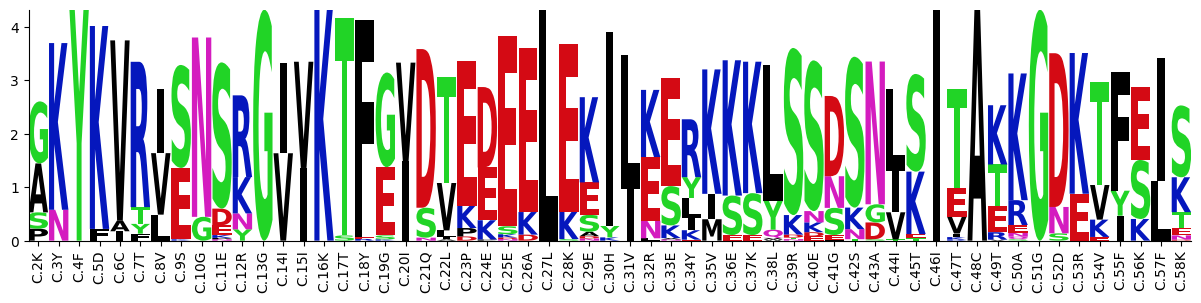

In [ ]:
import logomaker as lm
import matplotlib.pyplot as plt

def plot_logo(control_pose, design_seqs:list[str], only_pos:list[int]=None,
              only_chains:list[str]=None, fig_size:tuple[int]=(15, 3),
              save_fig:bool=False, png_name:str='webblogo.png'):

  if only_chains is not None and only_pos is not None:
    print("Pls specify only one of the two options, ether only_chains or only_pos")
    return

  design_seqs = [s.replace('/', '') for s in design_seqs]
  design_mat = lm.alignment_to_matrix(design_seqs)
  design_mat = lm.transform_matrix(design_mat, from_type='counts',
                                  to_type='information', pseudocount=0)

  control_seq = control_pose.sequence()
  if only_pos:
    only_pos = only_pos.replace(' ', '')
    pos_tuple = [(p[0], int(p[1:])) for p in only_pos.split(',')]
    positions = []
    seen = set()
    for i in range(1, len(control_seq)):
      if not control_pose.residue(i).is_protein(): continue
      resnum, chain, _ = control_pose.pdb_info().pose2pdb(i).split(' ')
      if (chain, int(resnum)) in pos_tuple:
        positions.append(i)
        seen.add((chain, int(resnum)))

    unseen = [t for t in pos_tuple if t not in seen]
    if unseen:
      print("Not in pose: ", unseen)

    design_mat = design_mat.iloc[[x-1 for x in positions], :]
    design_mat.index = [i for i, _ in enumerate(positions)]
  elif only_chains:
    chains = [x for x in only_chains.split(',')]
    positions = []
    lab = []
    for i in range(1, len(control_seq)):
      if not control_pose.residue(i).is_protein(): continue
      resnum, chain, _ = control_pose.pdb_info().pose2pdb(i).split(' ')
      if chain in chains:
        lab.append(f'{chain}.{resnum}')
        positions.append(i)

    design_mat = design_mat.iloc[[x-1 for x in positions], :]
    design_mat.index = [i for i, _ in enumerate(positions)]

  # Plot
  fig, ax = plt.subplots(figsize=fig_size)
  lm.Logo(design_mat, color_scheme='weblogo_protein', ax=ax)

  if only_pos:
    ax.set_xticks([i for i, _ in enumerate(positions)])
    lab = zip(only_pos.split(','), positions)
    ax.set_xticklabels([f'{l[0]}.{l[1:]}{control_seq[p-1]}' for i, (l, p) in enumerate(lab)])
  elif only_chains:
    ax.set_xticks([i for i, _ in enumerate(positions)])
    lab = zip(lab, positions)
    ax.set_xticklabels([f'{l}{control_seq[i-1]}' for l, i in lab], rotation=90)
  else:
    ax.set_xticks([i for i, _ in enumerate(design_mat.index)])
    ax.set_xticklabels([f'{i+1}{control_seq[i]}' for i in design_mat.index], rotation=90)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  if save_fig:
    plt.savefig(png_name, dpi=300, bbox_inches='tight')
  else:
    plt.show()


#@title Plot sequence logo
mpnn_csv = "" #@param {type:"string"}
#@markdown - Specify a csv file from a mpnn run to plot
#@markdown - Leave empty to use the latest generated .csv file

mode = "only_chain" #@param ["full", "only_pos", "only_chain"] {type:"string"}
selection = 'C' #@param {type:"string"}
#@markdown - Specify which parts of the logo you wanna seq, either
#@markdown  - `full` - full sequence logo (can be large), selection is ignored!
#@markdown  - `only_pos` - specify a list of residues (pdb numbering) to show with native amino acid labeling, e.g. 'A10,A43,B10'
#@markdown  - `only_chain` - specify a single chain to show

csv = mpnn_prefix + ".csv"
if mpnn_csv != "":
  csv = mpnn_csv
else:
  csv = mpnn_prefix + ".csv"
df = pd.read_csv(csv)
print(f"Plotting {csv}")

original_pose = pyrosetta.pose_from_file(pdb_path)
if mode == "full":
  plot_logo(original_pose, df["seq"], fig_size=(15, 3), only_chains=chains)
elif mode == "only_pos":
  plot_logo(original_pose, df["seq"], fig_size=(15, 3), only_pos=selection)
elif mode == "only_chain":
  plot_logo(original_pose, df["seq"], fig_size=(15, 3), only_chains=selection)

In [ ]:
# USER OPTIONS
#@title **Filter top N** results by MPNN score

# @markdown Lower MPNN score is better (more likely under the model) and experiments also have shown a correlation
# @markdown
# @markdown If you have the compute power you should just fold all MPNN sequences. We usually make 5-10 per designed backbone.

number_of_results=3 #@param {type:"integer"}
reverse=True #@param {type:"boolean"}
field_to_sort_by = 'score'

df.sort_values(by=field_to_sort_by, ascending=reverse, inplace=True)
df_filter = df.head(number_of_results).copy()
data_table.DataTable(df_filter.round(3))

,Unnamed: 0,score,seqid,seq
43,43,0.803,0.396,MIKIKVKIKKKEEEIEIEKEVESDEEFEKVLKEIEIIKKKNPEEVE...
64,64,0.803,0.385,KLKVKAKIKKEDEEIEIEREVESEEEFEKVLKELEKVKEKNPEEVE...
117,117,0.804,0.352,KIKIDVIIEKEDEKEEIKKEVESKEEFEEVLEEIEKVKEKNPEKVK...


In [ ]:
#@title ### **Visualize probabilities** from ProteinMPNN
mode = "unconditional" #@param ["unconditional", "conditional", "conditional_fix_pos"]
#@markdown - `unconditional` - P(sequence | structure)
#@markdown - `conditional` - P(sequence | structure, sequence)
#@markdown - `conditional_fix_pos` - P(sequence[not_fixed] | structure, sequence[fix_pos])
show = "all"
import plotly.express as px
from scipy.special import softmax
from colabdesign.mpnn.model import residue_constants
L = sum(mpnn_model._lengths)
fix_pos = mpnn_model._inputs.get("fix_pos",[])
free_pos = np.delete(np.arange(L),fix_pos)

if mode == "conditional":
  ar_mask = 1-np.eye(L)
  logits = mpnn_model.score(ar_mask=ar_mask)["logits"]
  pdb_labels = None
elif mode == "conditional_fix_pos":
  assert "fix_pos" in mpnn_model._inputs, "no positions fixed"
  ar_mask = 1-np.eye(L)
  p = np.delete(np.arange(L),mpnn_model._inputs["fix_pos"])
  ar_mask[free_pos[:,None],free_pos[None,:]] = 0
  logits = mpnn_model.score(ar_mask=ar_mask)["logits"]
  logits = logits[free_pos]
  pdb_labels = np.array([f"{i}_{c}" for c,i in zip(mpnn_model.pdb["idx"]["chain"], mpnn_model.pdb["idx"]["residue"])])
  pdb_labels = pdb_labels[free_pos]
else:
  ar_mask = np.zeros((L,L))
  logits = mpnn_model.score(ar_mask=ar_mask)["logits"]
  pdb_labels = None

pssm = softmax(logits,-1)
np.savetxt(mpnn_prefix + ".pssm",pssm)


title = {
        'text': f"<b>{mode} probabilities MPNN design - {pdb}<b>",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
}
fig = px.imshow(np.array(pssm).T,
               labels=dict(y="amino acids", color="probability", x="positions"),
               y=residue_constants.restypes + ["X"],
               x=pdb_labels,
               zmin=0,
               zmax=1,
               template="simple_white",
               origin="lower"
              )
fig.update_xaxes(side="top")
# fig.update_layout(title=title)
fig.show()

In [ ]:
%%time
#@title **Run AlphaFold prediction** on ProteinMPNN sequences

#@markdown We do not recommend predicting a high number of sequences as it takes a while (depending on sequence length)

#@markdown ### Options
outfolder = "output_af" #@param {type: "string"}
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
#@markdown - How many copies (dimer, trimer) are in a "single" structure

num_recycles = 3 #@param ["0","1","2","3"] {type:"raw"}
inital_guess = True #@param {type:"boolean"}
use_multimer = False #@param {type:"boolean"}
use_templates = True #@param {type:"boolean"}
rm_template_interchain = False
use_filtered_results = True #@param {type:"boolean"}
#@markdown - Use filtered results from ProteinMPNN (see above).

protocol = "fixbb" #@param ["fixbb","binder", "partial"] {type:"raw"}
best_metric = "dgram_cce" #@param ["dgram_cce", "plddt", "ptm", "rmsd"]
#@markdown - By which metric the best model is selected,
#@markdown - `dgram_cce` and `rmsd` is not allowed with protocol "binder"


# where pdb files will be save:
assert outfolder != "", "Please specify a output folder for the alphafold predictions"
s = str(pdb_path).split('/')[-1].replace('.pdb', '_mpnn_pred')
afoutfolder = os.path.join(outfolder, s)
if not os.path.isdir(afoutfolder):
  os.system(f"mkdir -p {afoutfolder}")
else:
  os.system(f"rm {afoutfolder}/*")

if use_filtered_results:
  input_data = df_filter.copy()
else:
  input_data = df.copy()

from colabdesign.af import mk_af_model
af_args = [pdb_path, chains, homooligomer,
           use_multimer, use_templates]

# if "af_arg_current" not in dir() or af_args != af_arg_current:
af_model = mk_af_model(
    protocol=protocol,
    use_multimer=use_multimer,
    use_templates=use_templates,
    best_metric=best_metric,
    initial_guess=inital_guess,
)
af_model.prep_inputs(pdb_path,chains,homooligomer=homooligomer)
af_arg_current = [x for x in af_args]

af_model.restart()
af_model.set_opt("template", rm_ic=rm_template_interchain)

with tqdm.notebook.tqdm(total=input_data["seq"].shape[0], bar_format=TQDM_BAR_FORMAT) as pbar:
  for n, S in enumerate(input_data["seq"]):
    seq = S[:af_model._len]
    af_model.predict(seq=seq,
                    num_recycles=num_recycles,
                    num_models=num_models,
                    verbose=False)
    (rmsd, ptm, plddt) = (af_model.aux["log"][k] for k in ["rmsd","ptm","plddt"])
    af_model.aux["log"]["composite"] = ptm * plddt
    af_model._save_results(save_best=True, verbose=False)
    af_model.save_current_pdb(f"{afoutfolder}/model_{n}.pdb")
    af_model._k += 1
    pbar.update(1)

af_model.save_pdb(f"{afoutfolder}/best.pdb")

data = []
labels = ["dgram_cce","plddt","ptm","i_ptm","rmsd","composite","mpnn","seqid","seq"]
for n, af in enumerate(af_model._tmp["log"]):
  data.append([af["dgram_cce"],
               af["plddt"],
               af["ptm"],
               af["i_ptm"],
               af["rmsd"],
               af["composite"],
               input_data["score"].iloc[n],
               input_data["seqid"].iloc[n],
               input_data["seq"].iloc[n]])

df = pd.DataFrame(data, columns=labels)
df['idx'] = range(0, len(df))

df.to_csv(f'{afoutfolder}/alphafold_results.csv')
data_table.DataTable(df.sort_values("dgram_cce").round(3))

  0%|          | 0/3 [elapsed: 00:00 remaining: ?]

CPU times: user 34.2 s, sys: 3.85 s, total: 38.1 s
Wall time: 44.5 s


,dgram_cce,plddt,ptm,i_ptm,rmsd,composite,mpnn,seqid,seq,idx
0,1.531,0.913,0.763,0.0,0.762,0.696,0.811,0.418,SIKIKVKIEKEDEEIEIEKEVDSEEEFEKVLKEIEIVKEKNPKKVE...,0
1,1.536,0.911,0.752,0.0,0.761,0.685,0.812,0.396,MIKIKVKIKKEDKEINIEKEVESEEEFEEVLKEIEIVKKENPEEVE...,1
2,1.599,0.896,0.730,0.0,0.791,0.654,0.815,0.407,KIKIKVKIKKEDEEIEIEKEVESEEELEKVFKEIEKVKEKNPEKVE...,2


In [ ]:
#@title Display predictions and original (optional) {run: "auto"}
#@markdown We recommend downloading the structures and visualize them in pyMol for more flexibility.

show_best = True #@param {type:"boolean"}
show_idx = 2 #@param {type:"integer"}
#@markdown - Enter index of protein to show, if `show_best` is disabled.
#@markdown - Note: these are NOT sorted and correspond to
#@markdown the index in pandas dataframe above.
color = "pLDDT" #@param ["pLDDT", "rainbow"]
show_sidechains = True #@param {type:"boolean"}
#show_mainchains = False #@param {type:"boolean"}
color_HP = False #@param {type:"boolean"}
#animate = False #@param {type:"boolean"}
##@markdown - if `num_models` > 1, will iterate through the models when `animate` is enabled.

s = str(pdb_path).split('/')[-1].replace('.pdb', '_mpnn_pred')
# s = '7JZM_mpnn_pred'
afout = os.path.join(outfolder, s)

original_structure = pdb_to_string(pdb_path)

if show_best:
  show_idx=df.sort_values("dgram_cce").iloc[0]["idx"]
  print(f"SHOWING: {show_idx}")

chosen_model_path=f"{afout}/model_{show_idx}.pdb"
pdb_str = pdb_to_string(chosen_model_path)

print(pdb_path, chosen_model_path)
aligned_pdb_path = align_pdbs(pdb_path, chosen_model_path)
aligned_pdb_str = pdb_to_string(chosen_model_path)

show_mainchains=False
animate=False

compare_poses(original_structure, aligned_pdb_str, color, show_sidechains, show_mainchains, animate, color_HP)

SHOWING: 0
pdbfolder/1QYS_A.pdb output_af/1QYS_A_mpnn_pred/model_0.pdb
RMSD before alignment:0.7624765038490295
RMSD after alignment:0.7624765299295693


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# **General helper functions**

In [ ]:
#@title **Display pdbs**

folder = "pdbfolder" #@param {type: "string"}
name = "" # @param {type: "string"}
colorscheme = "chain" #@param ["rainbow", "chain", "pLDDT"]
show_sidechains = True #@param {type:"boolean"}

f = os.path.join(folder, name + '.pdb')
assert os.path.isfile(f), f"Specified PDB file not found: {f}"
plot_pdb(f, colorscheme, show_sidechains)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title **Identify different protein layer residues** (core, boundary, surface)

import os
from pyrosetta import pose_from_pdb, init
from pyrosetta.rosetta.core.select.residue_selector import (
    LayerSelector, ChainSelector, OrResidueSelector, AndResidueSelector
)

# init("-corrections::beta_nov16 -ignore_unrecognized_res true -mute all -out:level 0")

def select_surface_residues(pdbfile, surface=0, boundary=0, core=0, chains:str=""):
    pose = pose_from_pdb(pdbfile)
    surface_selector = LayerSelector()
    surface_selector.set_layers(core, boundary, surface) # core, boundary, surface
    if chains != "":
        print(f"Selecting residues only from chains: {chains}")
        chains = chains.split(',')
        chain_selectors = OrResidueSelector()
        for chain in chains:
            chain_selectors.add_residue_selector(ChainSelector(chain))
        and_selector = AndResidueSelector(chain_selectors, surface_selector)
        surface_selector = and_selector
    res = []
    for i, b in enumerate(surface_selector.apply(pose), start=1):
        # List contains 1 if residue on surface
        if not b: continue

        # In this we skip glycines -> no sidechain, maybe bad
        residue = pose.residue(i)
        if not residue.is_protein(): continue
        res.append(str(pose.pdb_info().pose2pdb(i).replace(' ', '')))
    return ','.join([f'{r[-1]}{r[:-1]}' for r in res])

# USER OPTIONS
#@markdown ### Input
pdb ='' #@param {type:"string"}
#@markdown - four letter PDB code will automatically downloaded from the PDB.
#@markdown - providing a UniProt ID will download the AF2 model from the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/)
#@markdown - leave blank to get an upload prompt and use a pdb from your system

pdbfolder = "pdbfolder" #@param {type:"string"}
assert pdbfolder != "", "Please provide a folder name for the downloaded models"
#@markdown - Specify an pdbfolder folder for the downloaded models to keep track of them


#@markdown ### Settings
chains = "A" #@param {type: "string"}
#@markdown - Specify a chain to select parts from, multiple chains can be separated by comma. e.g. "A,B"
#@markdown - leave empty to select full structure


Surface = False #@param {type:"boolean"}
Boundary = False #@param {type:"boolean"}
Core = True #@param {type:"boolean"}

pdbpath = get_pdb(pdb, pdbfolder)
res = select_surface_residues(pdbpath, surface=Surface, core=Core, boundary=Boundary, chains=chains)
print(f"Residues:\n{res}")


Selecting residues only from chains: A
Residues:
A3,A9,A12,A16,A29,A32,A36,A39,A51,A55,A62


In [ ]:
#@title **Select Neighborhood** of one (or multiple) center residues

import os
from pyrosetta import pose_from_pdb, init
from pyrosetta.rosetta.core.select.residue_selector import LayerSelector

# init("-corrections::beta_nov16 -ignore_unrecognized_res true -mute all -out:level 0")

def select_neighborhood_of_residue(pdbfile, residues:str, distance:float=10.0):
    pose = pose_from_pdb(pdbfile)
    resi = residues.replace(' ', '').split(',')
    assert len(resi) > 0, "No residues were found, Parsed residues: " + str(resi)
    index_selector = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector()
    for r in resi:
        index_selector.append_index(pose.pdb_info().pdb2pose(r[0], int(r[1:])))

    neighbourhood = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector()
    neighbourhood.set_focus( index_selector.apply(pose) )
    neighbourhood.set_distance(distance)
    res = []
    for i, b in enumerate(neighbourhood.apply(pose), start=1):
        if not b: continue
        residue = pose.residue(i)
        if not residue.is_protein(): continue
        res.append(str(pose.pdb_info().pose2pdb(i).replace(' ', '')))
    return ','.join([f'{r[-1]}{r[:-1]}' for r in res])

# USER OPTIONS
#@markdown ### Input
pdb ='1SSC' #@param {type:"string"}
#@markdown - four letter PDB code will automatically downloaded from the PDB.
#@markdown - providing a UniProt ID will download the AF2 model from the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/)
#@markdown - leave blank to get an upload prompt and use a pdb from your system

pdbfolder = "pdbfolder" #@param {type:"string"}
assert pdbfolder != "", "Please provide a folder name for the downloaded models"
#@markdown - Specify an pdbfolder folder for the downloaded models to keep track of them

#@markdown ### Settings
center_res = "A10,A12" #@param {type:"string"}
#@markdown - Specify one or multiple residues as center residues for the selection
#@markdown - Only the format `[CHAIN][RESNUM]` is allowed, e.g. A10,A34
distance  = 10.0 #@param {type:"raw"}
assert float(distance), "Distance converstion to float was not succesfull"
assert float(distance) > 0, "Distance must be greater than 0"

pdbpath = get_pdb(pdb, pdbfolder)
print(f"Residues:\n{select_neighborhood_of_residue(pdbpath, residues=center_res, distance=distance)}")

In [ ]:
#@title **Select Interface** between two chains
from pyrosetta import pose_from_file, init
from pyrosetta.rosetta.core.select.residue_selector import (
    ChainSelector, InterGroupInterfaceByVectorSelector, AndResidueSelector
)
import numpy as np

# init('-mute all')

def select_interface_residues(pdbfile:str, binder_chain:str, target_chain:str,
                              nearby_atom_cutoff:float=6.0,
                              vector_dist_cutoff:float=8.0,
                              only_binder_residues:bool=True):
    pose = pose_from_file(pdbfile)

    binder_sel = ChainSelector(binder_chain)
    target_sel = ChainSelector(target_chain)
    # Check if selections are not empty (chain not in pose)
    assert np.any(binder_sel.apply(pose)), f'Specified binder chain "{binder_chain}" not found in pose'
    assert np.any(target_sel.apply(pose)), f'Specified target chain "{target_chain}" not found in pose'

    interface = InterGroupInterfaceByVectorSelector()
    interface.group1_selector(binder_sel)
    interface.group2_selector(target_sel)

    interface.nearby_atom_cut(nearby_atom_cutoff)
    interface.vector_dist_cut(vector_dist_cutoff)

    if only_binder_residues:
        and_selector = AndResidueSelector(binder_sel, interface)
        vec = and_selector.apply(pose)
    else:
        vec = interface.apply(pose)

    res = []
    for i, b in enumerate(vec, start=1):
        # List contains 1 if residue is in interface
        if not b: continue

        residue = pose.residue(i)
        if not residue.is_protein(): continue
        res.append(str(pose.pdb_info().pose2pdb(i).replace(' ', '')))
    return ','.join([f'{r[-1]}{r[:-1]}' for r in res])


# USER OPTIONS
#@markdown ### Input
pdb ='7JZM' #@param {type:"string"}
#@markdown - four letter PDB code will automatically downloaded from the PDB.
#@markdown - providing a UniProt ID will download the AF2 model from the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/)
#@markdown - leave blank to get an upload prompt and use a pdb from your system

pdbfolder = "pdbfolder" #@param {type:"string"}
assert pdbfolder != "", "Please provide a folder name for the downloaded models"
#@markdown - Specify an pdbfolder folder for the downloaded models to keep track of them

#@markdown ### Settings
binder_chain = "A" #@param {type:"string"}
target_chain = "B" #@param {type:"string"}
#@markdown - Specify the chain for the binder and the target chain
#@markdown - Only single chains are allowed

nearby_atom_cutoff  = 6.0 #@param {type:"raw"}
vector_dist_cutoff = 8.0 #@param {type:"raw"}
assert float(nearby_atom_cutoff) or float(vector_dist_cutoff), "Distance converstion for one setting to float was not succesfull"
assert (float(nearby_atom_cutoff) > 0) or (float(vector_dist_cutoff) > 0), "Distance must be greater than 0"

get_only_binder_residues = True #@param {type:"boolean"}
#@markdown - Return only the interface residues of the binder chain, else return also interface from target

kwargs = {
    "binder_chain": binder_chain,
    "target_chain": target_chain,
    "nearby_atom_cutoff": nearby_atom_cutoff,
    "vector_dist_cutoff": vector_dist_cutoff,
    "only_binder_residues": get_only_binder_residues
}

pdbpath = get_pdb(pdb, pdbfolder)
# f = './7jzm.pdb'
res = select_interface_residues(pdbpath, **kwargs)
print(f"Residues:\n{res}")

In [ ]:
#@title **Calculate interface metrics**
#@markdown ### Input
pdb ='6YWC_ABC_thread_mpnn_0' #@param {type:"string"}
#@markdown - four letter PDB code will automatically downloaded from the PDB.
#@markdown - providing a UniProt ID will download the AF2 model from the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/)
#@markdown - leave blank to get an upload prompt and use a pdb from your system

pdbfolder = "thread_seq" #@param {type:"string"}
#@markdown - Specify an pdbfolder folder for the model

#@markdown ### Settings
binder_chain = "A" #@param {type:"string"}
target_chain = "B,C" #@param {type:"string"}
#@markdown - Specify the chain for the binder and the target chain
#@markdown - Only single chains are allowed

path = os.path.join(pdbfolder, pdb + '.pdb')
assert os.path.isfile(path), f"Specified PDB file not found: {path}"
dimer_pose = pyrosetta.pose_from_pdb(path)
chains = [a[1] for a in pyrosetta.rosetta.core.pose.conf2pdb_chain(dimer_pose).items()]

# Check chains
print(chains)
for c in binder_chain.split(','):
  if c not in chains:
    raise ValueError(f"Chain {c} not in pose")

for c in target_chain.split(','):
  if c not in chains:
    raise ValueError(f"Chain {c} not in pose")

protocol = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects().create_from_string(
f"""
<ROSETTASCRIPTS>
    <SCOREFXNS>
        <ScoreFunction name="sfxn_clean" weights="beta_nov16" />
    </SCOREFXNS>

    <RESIDUE_SELECTORS>
        <Chain name="chainA" chains="{binder_chain}" />
        <Chain name="chainB" chains="{target_chain}" />
        <ScoreTermValueBased name="clashing_res" score_type="fa_rep" score_fxn="sfxn"  lower_threshold="3" upper_threshold="99999" />

    </RESIDUE_SELECTORS>
    <TASKOPERATIONS>
        <IncludeCurrent name="ic" /> //includes input pdbs rotamers
        <LimitAromaChi2 name="limitaro" chi2max="110" chi2min="70" include_trp="1" /> //disallow extreme aromatic rotamers
        <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" /> //use ex1 ex2 rotamers
        <RestrictToRepacking name="repack_only" />  //for minimize/repack
    </TASKOPERATIONS>

    <FILTERS>
        <NetCharge name="chargeA" chain="1" confidence="0" />
        <ShapeComplementarity name="shape_comp" min_sc="0.6" verbose="1" quick="0" residue_selector1="chainA" residue_selector2="chainB" write_int_area="1" write_median_dist="1" confidence="0" />
        <ExposedHydrophobics name="exposed_hydrop" sasa_cutoff="20" threshold="0" confidence="0"/>
        <ContactMolecularSurface name="cms" distance_weight="0.5" use_rosetta_radii="true" apolar_target="0"
        target_selector="chainA" binder_selector="chainB" confidence="0" />

        <BuriedUnsatHbonds name="vbuns"  report_all_heavy_atom_unsats="true" scorefxn="sfxn_clean" ignore_surface_res="false" print_out_info_to_pdb="true" atomic_depth_selection="5" burial_cutoff="1000" residue_surface_cutoff="42.5" dalphaball_sasa="0" confidence="0"  only_interface="false"  />
	    	<BuriedUnsatHbonds name="sbuns" report_all_heavy_atom_unsats="true" scorefxn="sfxn_clean" cutoff="4" residue_surface_cutoff="42.5" ignore_surface_res="false" print_out_info_to_pdb="true" dalphaball_sasa="0" probe_radius="1.1" atomic_depth_selection="5.5" atomic_depth_deeper_than="false" only_interface="false" confidence="0" />
    </FILTERS>

    <MOVERS>

        <MinMover name="minimize_sc_all" scorefxn="sfxn_clean" bb="0" chi="1" />
        <InterfaceAnalyzerMover name="analyze_interface" scorefxn="sfxn_clean"
        packstat="1" interface_sc="1" use_jobname="1"
        jump="1" scorefile_reporting_prefix="IA" />

        <ddG name="ddG_no_repack" translate_by="1000" scorefxn="sfxn_clean" task_operations="repack_only,ic,ex1_ex2" relax_mover="minimize_sc_all"
            repack_bound="0"
            relax_bound="0"
            repack_unbound="0"
            relax_unbound="1"
        jump="1"
        dump_pdbs="0"   />
    </MOVERS>
    <SIMPLE_METRICS>
        <SapScoreMetric name="sap_score" />
        <SelectedResiduesPyMOLMetric name="clashing_res" residue_selector="clashing_res" custom_type="clashing_res" />
    </SIMPLE_METRICS>
    <PROTOCOLS>
        <Add mover="minimize_sc_all" />
        <Add mover="analyze_interface" />
        <Add mover="ddG_no_repack" />
        <Add filter="chargeA" />
        <Add filter="exposed_hydrop" />
        <Add filter="cms" />
        <Add filter="vbuns" />
        <Add filter="sbuns" />
        <Add metrics="sap_score" />
        <Add metrics="clashing_res" />
        <Add filter="shape_comp" />
    </PROTOCOLS>
</ROSETTASCRIPTS>

""").get_mover("ParsedProtocol")
print("Finished parsed protocol")
protocol.apply(dimer_pose)

# Most important metrics
print(f"""
shape complementarity  : {dimer_pose.scores['shape_comp']:.3f} \t\t# Higher is better.
ddg                    : {dimer_pose.scores['ddg']:.3f} \t# Energy of binding between the two subunits (lower is better)
contact molecular surf : {dimer_pose.scores['cms']:.3f} \t# Similar to SC, but even more sensitive to smaller gaps. Higer is better (not normalised to surface)
SASA                   : {dimer_pose.scores['IA_dSASA_int']:.3f} \t# Size of the interface
Very buried unsat hbond: {dimer_pose.scores['vbuns']:.3f} \t# Buried unsat H-bonds. Lower is better. Can be really hurtful to design, but sometimes not accurate. Should be <2
Surface unsat hbond    : {dimer_pose.scores['sbuns']:.3f} \t# Not such a big problem, water can come in.
SAP score              : {dimer_pose.scores['sap_score']:.3f} \t# Solubility score
""")


['A', 'B', 'C']
Finished parsed protocol

shape complementarity  : 0.658 		# Higher is better.
ddg                    : -105.351 	# Energy of binding between the two subunits (lower is better)
contact molecular surf : 1531.101 	# Similar to SC, but even more sensitive to smaller gaps. Higer is better (not normalised to surface)
SASA                   : 4212.902 	# Size of the interface
Very buried unsat hbond: 35.000 	# Buried unsat H-bonds. Lower is better. Can be really hurtful to design, but sometimes not accurate. Should be <2
Surface unsat hbond    : 47.000 	# Not such a big problem, water can come in.
SAP score              : 139.627 	# Solubility score



In [ ]:
#@title **Thread sequence** on structure

#@markdown The threaded pose will be stored in **thread_seq/{pdb}_thread_mpnn_{seq_index}.pdb**

def thread_seq_on_pose(pose, seq):
  assert len(pose.sequence()) == len(seq) , "Sequence length does not match pose length"
  protocol = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects().create_from_string(
  f"""
  <ROSETTASCRIPTS>
      <SCOREFXNS>
          <ScoreFunction name="sfxn_clean" weights="beta_nov16" />
      </SCOREFXNS>
      <MOVERS>
          <SimpleThreadingMover name="thread_seq" pack_neighbors="true"
            neighbor_dis="6.0" start_position="1"
            thread_sequence="{seq}" scorefxn="sfxn_clean" pack_rounds="5" />
      </MOVERS>
      <PROTOCOLS>
          <Add mover="thread_seq" />
      </PROTOCOLS>
  </ROSETTASCRIPTS>
  """).get_mover("ParsedProtocol")
  protocol.apply(pose)
  return pose

#@markdown ### Input
pdb ='6YWC_ABC' #@param {type:"string"}
#@markdown - four letter PDB code will automatically downloaded from the PDB.
#@markdown - providing a UniProt ID will download the AF2 model from the [AlphaFold Protein Structure Database](https://alphafold.ebi.ac.uk/)
#@markdown - leave blank to get an upload prompt and use a pdb from your system

pdbfolder = "pdbfolder" #@param {type:"string"}
#@markdown - Specify an pdbfolder where to find the model

#@markdown ### Settings
mpnn_csv = "output_mpnn/6YWC_mpnn.csv" #@param {type:"string"}
seq_index = 0 #@param {type:"integer"}
#@markdown - specify the mpnn csv (full path) for the designed sequences
#@markdown - specify the index of the sequence to thread on the pose

path = os.path.join(pdbfolder, pdb + '.pdb')
assert os.path.isfile(path), f"Specified PDB file not found: {path}"
seq_pose = pyrosetta.pose_from_pdb(path)

#Kasper ist doof

copy = seq_pose.clone()
seq = pd.read_csv(mpnn_csv).iloc[seq_index]['seq']
seq = seq.replace('/', '')
copy = thread_seq_on_pose(copy, seq)

print("Sequences\n=======")
print("Original: ", seq_pose.sequence())
print("Thread:\t  ", copy.sequence())
print("=======")

##
min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
min_mover.cartesian(False)
min_mover.max_iter(100)

sfxn = pyrosetta.get_score_function()
min_mover.score_function(sfxn)
min_mover.apply(copy)

!mkdir -p thread_seq
copy.dump_pdb(f"thread_seq/{pdb}_thread_mpnn_{seq_index}.pdb")

Sequences
Original:  QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKGLEWLAHIYWDDDKRYNPSLKSRLTISKDTSRNQVFLKITSVDTADTATYYCARLYGFTYGFAYWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTETYICNVNHKPSNTKVDKKVEPKRDIVLTQSPASLAVSLGQRATIFCRASQSVDYNGISYMHWFQQKPGQPPKLLIYAASNPESGIPARFTGSGSGTDFTLNIHPVEEEDAATYYCQQIIEDPWTFGGGTKLEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNRGEKYFDCTVSGERGIIKTYGIQLPEEALKEHVREYVEKLREGSAITITCTAGDRVFKFKD
Thread:	   QVTLKESGPGILQPSQTLSLTCSFSGFSLSTSGMGVSWIRQPSGKGLEWLAHIYWDDDKRYNPSLKSRLTISKDTSRNQVFLKITSVDTADTATYYCARLYGFTYGFAYWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTETYICNVNHKPSNTKVDKKVEPKRDIVLTQSPASLAVSLGQRATIFCRASQSVDYNGISYMHWFQQKPGQPPKLLIYAASNPESGIPARFTGSGSGTDFTLNIHPVEEEDAATYYCQQIIEDPWTFGGGTKLEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNRGEAKYKVRVSNSRGVVKTFGVDTEDDKLKEILE

True